In [20]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf

# Path to bird images
data_path = r"E:\work\Projects\DIY3 dataset\train"
img_size = (64, 64)  # Resize all images to this size

# Load and preprocess images
def load_images(data_path, img_size=(64, 64)):
    images = []
    for folder_name in sorted(os.listdir(data_path)):
        folder_path = os.path.join(data_path, folder_name)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                try:
                    img = load_img(img_path, target_size=img_size)
                    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
                    images.append(img)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}")
    return np.array(images)

images = load_images(data_path)
print(f"Loaded {images.shape[0]} images with shape {images.shape[1:]} for training.")


Loaded 30000 images with shape (64, 64, 3) for training.


In [21]:
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, LeakyReLU
from tensorflow.keras import Model

# Generator model
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = Dense(8 * 8 * 256, activation="relu")
        self.reshape = Reshape((8, 8, 256))
        self.conv1 = Conv2DTranspose(128, (5, 5), strides=2, padding='same', activation='relu')
        self.conv2 = Conv2DTranspose(64, (5, 5), strides=2, padding='same', activation='relu')
        self.conv3 = Conv2DTranspose(3, (5, 5), strides=2, padding='same', activation='tanh')

    def call(self, noise):
        x = self.fc(noise)
        x = self.reshape(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

# Discriminator model
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = Conv2D(64, (5, 5), strides=2, padding='same', activation=LeakyReLU(0.2))
        self.conv2 = Conv2D(128, (5, 5), strides=2, padding='same', activation=LeakyReLU(0.2))
        self.flatten = Flatten()
        self.fc = Dense(1)

    def call(self, img):
        x = self.conv1(img)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [22]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss


In [25]:
from matplotlib import pyplot as plt


generator = Generator()
discriminator = Discriminator()
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
batch_size = 32
noise_dim = 100  # Dimensionality of the random noise

@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise)

        real_output = discriminator(images)
        fake_output = discriminator(generated_images)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# Generate and save images
def generate_and_save_images(model, test_input):
    predictions = model(test_input)
    
    # Convert predictions from Tensor to NumPy array
    predictions = predictions.numpy()  # Add this line to convert tensor to numpy array
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        # Scale the images back to [0, 255] and convert to uint8
        plt.imshow((predictions[i] * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')
    plt.show()

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
        print(f"Epoch {epoch+1}, Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")
        generate_and_save_images(generator, tf.random.normal([16, noise_dim]))



Shape of images: (30000, 64, 64, 3)
Epoch 1, Gen Loss: 1.3251683712005615, Disc Loss: 1.8672267198562622


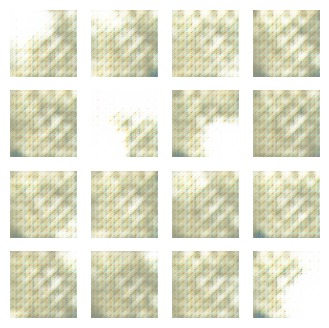

Epoch 2, Gen Loss: 1.4327967166900635, Disc Loss: 0.9311380982398987


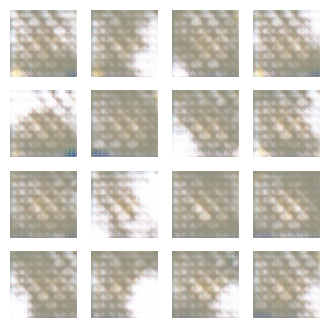

Epoch 3, Gen Loss: 2.5576391220092773, Disc Loss: 0.49256250262260437


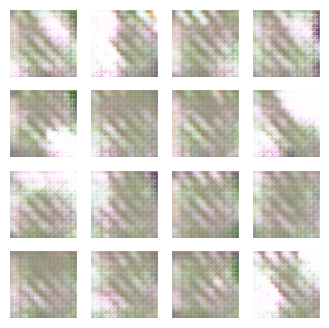

Epoch 4, Gen Loss: 2.0844478607177734, Disc Loss: 0.7389347553253174


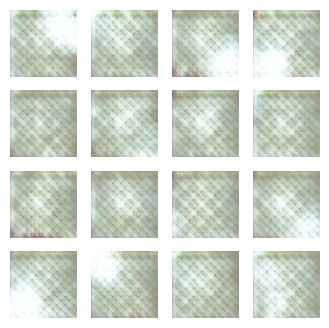

Epoch 5, Gen Loss: 3.156731367111206, Disc Loss: 0.284584105014801


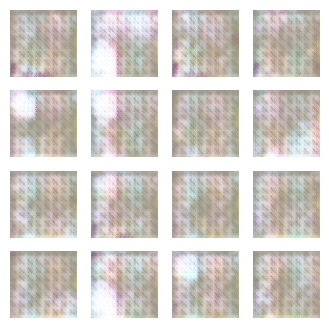

Epoch 6, Gen Loss: 2.0475680828094482, Disc Loss: 0.4687589108943939


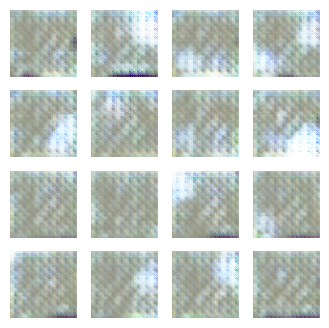

Epoch 7, Gen Loss: 1.4938451051712036, Disc Loss: 0.36041831970214844


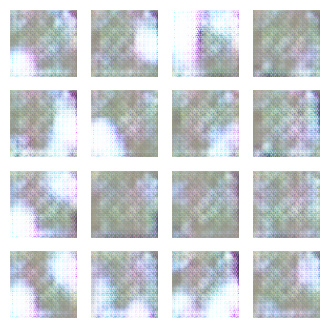

Epoch 8, Gen Loss: 3.1556296348571777, Disc Loss: 0.47139307856559753


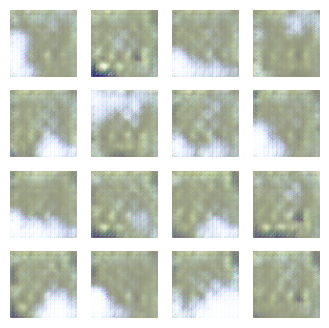

Epoch 9, Gen Loss: 1.143127679824829, Disc Loss: 0.502564013004303


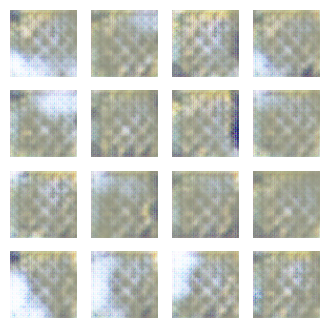

Epoch 10, Gen Loss: 2.7532896995544434, Disc Loss: 0.41112419962882996


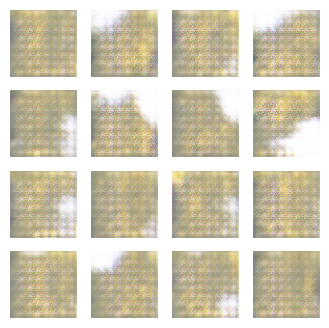

Epoch 11, Gen Loss: 2.5250205993652344, Disc Loss: 1.2999430894851685


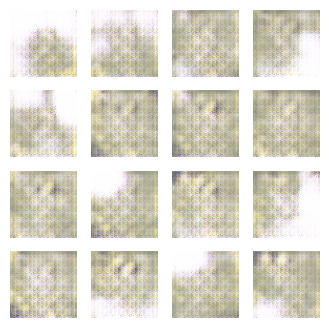

Epoch 12, Gen Loss: 2.7576966285705566, Disc Loss: 0.7309364676475525


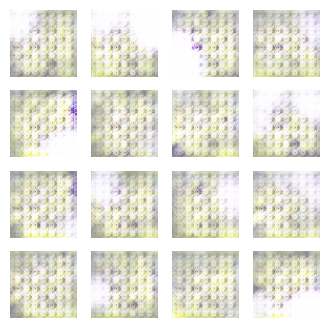

Epoch 13, Gen Loss: 1.665384292602539, Disc Loss: 0.5030696392059326


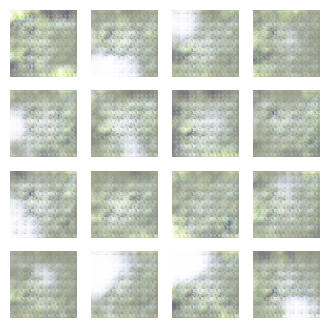

Epoch 14, Gen Loss: 3.498124599456787, Disc Loss: 0.6867139339447021


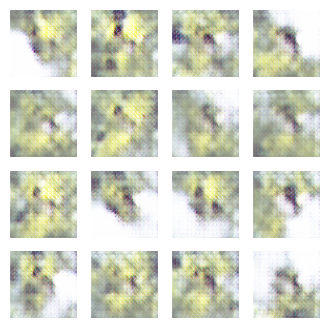

Epoch 15, Gen Loss: 1.858454704284668, Disc Loss: 0.8041414022445679


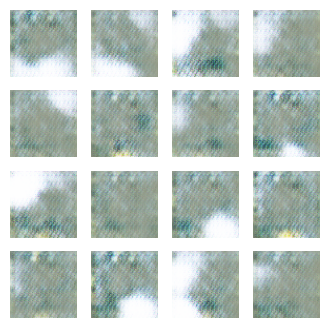

Epoch 16, Gen Loss: 3.32965087890625, Disc Loss: 0.12023593485355377


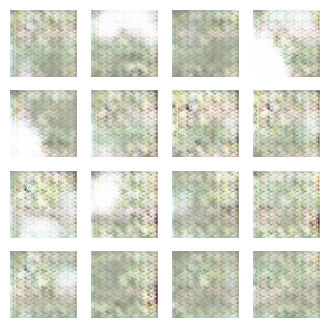

Epoch 17, Gen Loss: 1.2477654218673706, Disc Loss: 0.49481141567230225


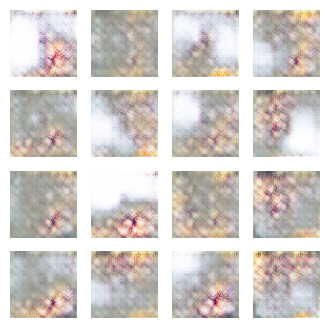

Epoch 18, Gen Loss: 0.8823875188827515, Disc Loss: 1.0542020797729492


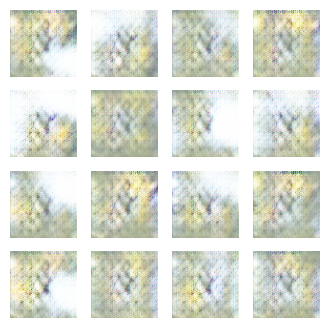

Epoch 19, Gen Loss: 1.7068185806274414, Disc Loss: 0.4430236220359802


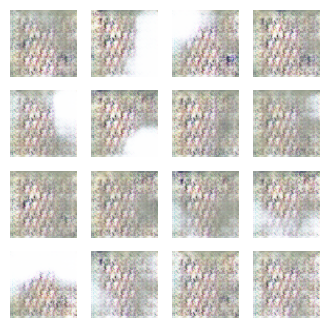

Epoch 20, Gen Loss: 1.2568674087524414, Disc Loss: 0.5920990705490112


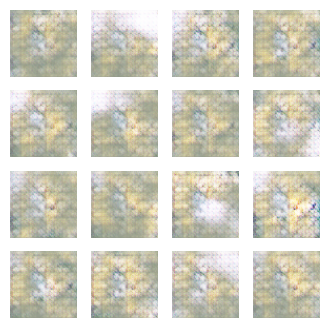

In [29]:
import tensorflow as tf
import numpy as np

# Your earlier image loading function
# images = load_images(data_path)  # Ensure this function is defined and works as expected

# Check the shape of images
print("Shape of images:", images.shape)

# Adjust BUFFER_SIZE based on the number of images
BUFFER_SIZE = images.shape[0]
BATCH_SIZE = 32

# Create TensorFlow dataset for training
if images.size == 0:
    raise ValueError("No images loaded. Please check the data loading process.")

train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Start training
train(train_dataset, epochs=20)


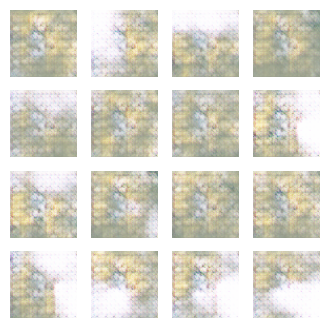

In [30]:
import matplotlib.pyplot as plt

# Generate and display new images
def generate_and_display_images(generator, num_images=16):
    noise = tf.random.normal([num_images, noise_dim])
    generated_images = generator(noise)
    
    # Convert predictions from Tensor to NumPy array
    generated_images = generated_images.numpy()
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(generated_images.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((generated_images[i] * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')
    plt.show()

generate_and_display_images(generator)
